In [1]:
!pip install pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler


In [3]:
spark = SparkSession.builder \
    .appName("Online Retail Clustering") \
    .getOrCreate()
print("SparkSession Created Successfully!")


SparkSession Created Successfully!


In [4]:
import urllib.request

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
file_name = "Online_Retail.xlsx"

urllib.request.urlretrieve(url, file_name)
print("Dataset downloaded successfully!")


Dataset downloaded successfully!


In [5]:
import pandas as pd

# Load the Excel file
df = pd.read_excel("Online_Retail.xlsx")

# Save as CSV
csv_file = "Online_Retail.csv"
df.to_csv(csv_file, index=False)
print("Excel file converted to CSV!")


Excel file converted to CSV!


In [6]:
data = spark.read.csv("Online_Retail.csv", header=True, inferSchema=True)
data.show(5)
data.printSchema()


+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows

roo

In [7]:
data.select([col for col in data.columns if data[col].isNull().any()]).show()


TypeError: 'Column' object is not callable

In [8]:
from pyspark.sql.functions import col, sum

data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()


+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [10]:
from pyspark.sql.functions import col, sum

# Count nulls in each column
data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()


+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [11]:
from pyspark.sql.functions import col

# Filter rows with any null value
rows_with_nulls = data.filter(
    " OR ".join([f"{c} IS NULL" for c in data.columns])
)
rows_with_nulls.show()


+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536414|    22139|                NULL|      56|2010-12-01 11:52:00|      0.0|      NULL|United Kingdom|
|   536544|    21773|DECORATIVE ROSE B...|       1|2010-12-01 14:32:00|     2.51|      NULL|United Kingdom|
|   536544|    21774|DECORATIVE CATS B...|       2|2010-12-01 14:32:00|     2.51|      NULL|United Kingdom|
|   536544|    21786|  POLKADOT RAIN HAT |       4|2010-12-01 14:32:00|     0.85|      NULL|United Kingdom|
|   536544|    21787|RAIN PONCHO RETRO...|       2|2010-12-01 14:32:00|     1.66|      NULL|United Kingdom|
|   536544|    21790|  VINTAGE SNAP CARDS|       9|2010-12-01 14:32:00|     1.66|      NULL|United Kingdom|
|   536544|    21791|VINTAGE

In [12]:
cleaned_data = data.dropna()
cleaned_data.show()


+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

In [14]:
data.printSchema()  # Displays the column names and data types
print(data.columns)  # Lists all column names


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)

['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [15]:
filled_data = data.fillna({"Quantity": 0})  # Replace nulls in 'Quantity' with 0
filled_data.show()


+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

In [16]:
filled_data = data.fillna({"Quantity": 0, "UnitPrice": 0})
filled_data.show()


+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

In [17]:
cleaned_data = data.dropna()
cleaned_data.show()


+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

In [18]:
filled_data = data.fillna(0)  # Replace all nulls with 0
filled_data.show()


+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

In [19]:
feature_columns = ["Quantity", "UnitPrice", "TotalRevenue"]


In [21]:
from pyspark.sql.functions import col

# Drop rows with missing values
cleaned_data = data.dropna()

# Filter for positive quantities and unit prices
filtered_data = cleaned_data.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))

# Add TotalRevenue column
filtered_data = filtered_data.withColumn("TotalRevenue", col("Quantity") * col("UnitPrice"))

# Show the processed data
filtered_data.show(5)


+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|      TotalRevenue|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|15.299999999999999|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|              22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|    

In [22]:
filtered_data.printSchema()
filtered_data.show(5)


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- TotalRevenue: double (nullable = true)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|      TotalRevenue|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|15.299999999999999|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom| 

In [23]:
from pyspark.ml.feature import VectorAssembler

feature_columns = ["Quantity", "UnitPrice", "TotalRevenue"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
vectorized_data = assembler.transform(filtered_data)

# Display the vectorized features
vectorized_data.select("features").show(5)


+--------------------+
|            features|
+--------------------+
|[6.0,2.55,15.2999...|
|    [6.0,3.39,20.34]|
|     [8.0,2.75,22.0]|
|    [6.0,3.39,20.34]|
|    [6.0,3.39,20.34]|
+--------------------+
only showing top 5 rows



In [24]:
filtered_data.printSchema()
filtered_data.show(5)


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- TotalRevenue: double (nullable = true)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|      TotalRevenue|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|15.299999999999999|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom| 

In [25]:
from pyspark.ml.clustering import KMeans


In [26]:
kmeans = KMeans(k=3, seed=42)
model = kmeans.fit(vectorized_data)


In [27]:
predictions = model.transform(vectorized_data)
predictions.show(5)


+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+--------------------+----------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|      TotalRevenue|            features|prediction|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+--------------------+----------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|15.299999999999999|[6.0,2.55,15.2999...|         0|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|    [6.0,3.39,20.34]|         0|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|              22.0|     [8.0,2.75,22.0]|         0|
|   536365|   84029G|KNITTED UNION FLA...|    

In [29]:
centers = model.clusterCenters()
print("Cluster Centers:")
for center in centers:
    print(center)



Cluster Centers:
[12.59821254  3.11649558 21.77971033]
[7.42150e+04 1.04000e+00 7.71836e+04]
[8.099500e+04 2.080000e+00 1.684696e+05]


In [30]:
predictions.groupBy("prediction").count().show()


+----------+------+
|prediction| count|
+----------+------+
|         1|     1|
|         0|397882|
|         2|     1|
+----------+------+



In [31]:
predictions.groupBy("prediction").agg(
    {"Quantity": "avg", "UnitPrice": "avg", "TotalRevenue": "avg"}
).show()


+----------+------------------+------------------+-----------------+
|prediction|    avg(UnitPrice)| avg(TotalRevenue)|    avg(Quantity)|
+----------+------------------+------------------+-----------------+
|         1|              1.04|           77183.6|          74215.0|
|         0|3.1164955790918003|21.779710326179515|12.59821253537481|
|         2|              2.08|          168469.6|          80995.0|
+----------+------------------+------------------+-----------------+



In [33]:
predictions_to_save = predictions.drop("features")
predictions_to_save.write.csv("clustering_results.csv", header=True)



In [35]:
predictions_to_save.write.csv("clustering_results.csv", header=True, mode="overwrite")



In [36]:
from pyspark.sql.functions import col


predictions_with_features = predictions.withColumn("features_str", col("features").cast("string"))
predictions_to_save = predictions_with_features.drop("features")  # Drop the original complex column


predictions_to_save.write.csv("clustering_results.csv", header=True, mode="overwrite")


In [38]:
from google.colab import files
files.download("clustering_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
!ls


clustering_results.csv	Online_Retail.csv  Online_Retail.xlsx  sample_data


In [41]:
predictions_to_save.write.csv("clustering_results.csv", header=True, mode="overwrite")


In [42]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [43]:
!pwd


/content


In [44]:
!ls


clustering_results.csv	Online_Retail.csv  Online_Retail.xlsx  sample_data


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the file into a pandas DataFrame
df = pd.read_csv("clustering_results.csv")

# Scatterplot for visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Quantity", y="TotalRevenue", hue="prediction", palette="viridis")
plt.title("Clustering Results")
plt.xlabel("Quantity")
plt.ylabel("Total Revenue")
plt.legend(title="Cluster")
plt.show()


IsADirectoryError: [Errno 21] Is a directory: 'clustering_results.csv'

In [47]:
!ls clustering_results.csv


part-00000-e8eb30b5-13c1-4cb0-b7cd-1a76c91d4938-c000.csv  _SUCCESS
part-00001-e8eb30b5-13c1-4cb0-b7cd-1a76c91d4938-c000.csv


In [48]:
!cat clustering_results.csv/part-* > combined_clustering_results.csv


In [49]:
import pandas as pd

df = pd.read_csv("combined_clustering_results.csv")
print(df.head())


  InvoiceNo StockCode                          Description Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER        6   
1    536365     71053                  WHITE METAL LANTERN        6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER        8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE        6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.        6   

                InvoiceDate UnitPrice CustomerID         Country TotalRevenue  \
0  2010-12-01T08:26:00.000Z      2.55    17850.0  United Kingdom         15.3   
1  2010-12-01T08:26:00.000Z      3.39    17850.0  United Kingdom        20.34   
2  2010-12-01T08:26:00.000Z      2.75    17850.0  United Kingdom         22.0   
3  2010-12-01T08:26:00.000Z      3.39    17850.0  United Kingdom        20.34   
4  2010-12-01T08:26:00.000Z      3.39    17850.0  United Kingdom        20.34   

  prediction                   features_str  
0          0  [6.0,2.55,15.2999999999999

<ipython-input-49-647812e04bed>:3: DtypeWarning: Columns (0,3,5,6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_clustering_results.csv")


In [50]:
from google.colab import files
files.download("combined_clustering_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
import pandas as pd
df = pd.read_csv("combined_clustering_results.csv")
print(df.head())


  InvoiceNo StockCode                          Description Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER        6   
1    536365     71053                  WHITE METAL LANTERN        6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER        8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE        6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.        6   

                InvoiceDate UnitPrice CustomerID         Country TotalRevenue  \
0  2010-12-01T08:26:00.000Z      2.55    17850.0  United Kingdom         15.3   
1  2010-12-01T08:26:00.000Z      3.39    17850.0  United Kingdom        20.34   
2  2010-12-01T08:26:00.000Z      2.75    17850.0  United Kingdom         22.0   
3  2010-12-01T08:26:00.000Z      3.39    17850.0  United Kingdom        20.34   
4  2010-12-01T08:26:00.000Z      3.39    17850.0  United Kingdom        20.34   

  prediction                   features_str  
0          0  [6.0,2.55,15.2999999999999

<ipython-input-51-e60f962105e8>:2: DtypeWarning: Columns (0,3,5,6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_clustering_results.csv")


In [53]:
print(df.dtypes)



InvoiceNo       object
StockCode       object
Description     object
Quantity        object
InvoiceDate     object
UnitPrice       object
CustomerID      object
Country         object
TotalRevenue    object
prediction      object
features_str    object
dtype: object


In [54]:
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
df["UnitPrice"] = pd.to_numeric(df["UnitPrice"], errors="coerce")
df["TotalRevenue"] = pd.to_numeric(df["TotalRevenue"], errors="coerce")


In [55]:
df = df.dropna(subset=["Quantity", "UnitPrice", "TotalRevenue"])


In [56]:
cluster_summary = df.groupby("prediction").agg(
    {"Quantity": "mean", "UnitPrice": "mean", "TotalRevenue": "mean"}
)
print(cluster_summary)


                Quantity  UnitPrice   TotalRevenue
prediction                                        
0              12.249586   3.147026      21.274761
1           74215.000000   1.040000   77183.600000
2           80995.000000   2.080000  168469.600000
0              14.366201   2.961665      24.340455


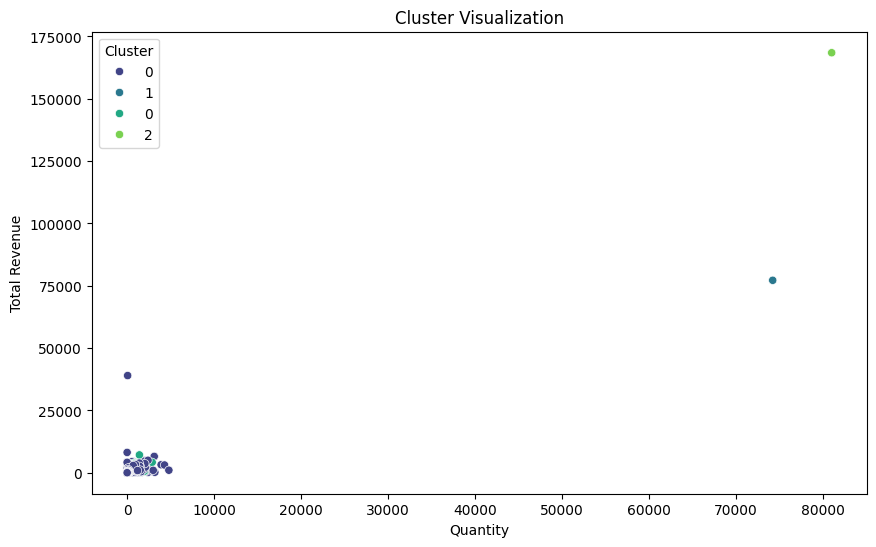

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Quantity", y="TotalRevenue", hue="prediction", palette="viridis")
plt.title("Cluster Visualization")
plt.xlabel("Quantity")
plt.ylabel("Total Revenue")
plt.legend(title="Cluster")
plt.show()


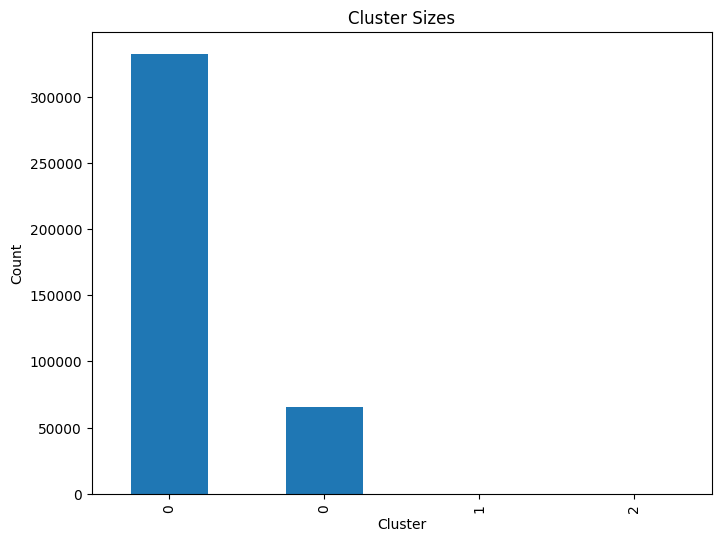

In [58]:
cluster_counts = df["prediction"].value_counts()
cluster_counts.plot(kind="bar", figsize=(8, 6), title="Cluster Sizes", xlabel="Cluster", ylabel="Count")
plt.show()


In [59]:
from pyspark.ml.clustering import KMeans

# Change the number of clusters
kmeans = KMeans(k=4, seed=42)  # Use k=4
model = kmeans.fit(vectorized_data)

# Get new predictions
new_predictions = model.transform(vectorized_data)

# Analyze the new clusters
new_predictions.groupBy("prediction").count().show()


+----------+------+
|prediction| count|
+----------+------+
|         1|     1|
|         3|     1|
|         0|397881|
|         2|     1|
+----------+------+

